In [1]:
# ---- Nested function ---- #
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy
import random

# # ---- BWR ---- #
# import bwr
# import emd
import pywt
# ---- Scipy ---- #
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


# ---- PyTorch ---- #
import torch
import torchvision
import torch.nn.functional as Func
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import torchvision.ops as ops
import tensorboard
from tensorboardX import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR,CosineAnnealingWarmRestarts

# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold


# ---- Matplotlib ---- #
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Summary ---- #
import pytorch_model_summary


In [2]:
def load_raw_data(df, sampling_rate, path):
    data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [3]:
sampling_rate = 500

ptb_xl_path = "/data/graduate/ptbxl_103/"

In [4]:
super_class = {}

classes_csv = pd.read_csv(ptb_xl_path+"scp_statements.csv")
classes_csv.rename(columns={"Unnamed: 0":"specific_class"}, inplace=True)
classes_csv["diagnostic_class"] = classes_csv["diagnostic_class"].fillna("OTHERS")

for i in range(len(classes_csv)):
    name = classes_csv.iloc[i].specific_class
    super_c = classes_csv.iloc[i].diagnostic_class
    super_class[name] = super_c

In [5]:
Y = pd.read_csv(ptb_xl_path+"ptbxl_database.csv", index_col="ecg_id")

In [6]:
class PTBXL(Dataset):
    
    def __init__(self, data_root, 
                folds=[1,2,3,4,5,6,7,8,9,10], 
                class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4},
                sampling_rate = 500,
                verbose=False,
                transform=None
                ):
        
            self.data_root = data_root
            y = pd.read_csv(os.path.join(self.data_root, 'ptbxl_database.csv'), index_col='ecg_id')
            self.folds = folds
            self.class_map = class_map
            self.sampling_rate = sampling_rate
            self.verbose = verbose
            self.transform = transform

            y = y.loc[y.strat_fold.isin(self.folds)]

             # Load scp_statements.csv for diagnostic aggregation
            agg_df = pd.read_csv(os.path.join(data_root, "scp_statements.csv"), index_col=0)
            self.agg_df = agg_df[agg_df.diagnostic == 1]

            # Apply diagnostic superclass
            y.scp_codes = y.scp_codes.apply(lambda x: ast.literal_eval(x))
            y['diagnostic_superclass'] = y.scp_codes.apply(self.aggregate_diagnostic)

            # Convert to Class numbers
            y["class_ids"] = y.diagnostic_superclass.apply(self.map_class_num)

            self.y = y

            if self.verbose:
                print("unique super classes=", self.agg_df.diagnostic_class.unique())
                print("unique folds=",self.y.strat_fold.unique())
                print(self.agg_df)
                print(self.y.scp_codes)
                print("Class labels=", self.y.diagnostic_superclass)
                print("Class ids=", self.y.class_ids)

    def aggregate_diagnostic(self, y_dic):
        tmp = []
        #print(y_dic)
        for key in y_dic.keys():
            if key in self.agg_df.index:
                tmp.append(self.agg_df.loc[key].diagnostic_class)
        #print("temp =",  tmp)
        return list(set(tmp))

    def map_class_num(self, class_labels):
        temp = []
        try:
            for l in class_labels:
                class_id = self.class_map[l]
                temp.append(class_id)
        except:
            print("These labels are wrong:", class_labels)
        return temp

    def read_row_data(self, data_path):
        signal, meta = wfdb.rdsamp(data_path)
        #data = np.array([signal for signal, meta in data])
        if self.verbose:
            print(signal)
            print(meta)
        return np.array(signal), meta
    
    # Powerline Noise Filtering
    def lowpass_filt(self, fs, low, order=5):
        nyq = 0.5 * fs # 250Hz
    #     lowcut = ((2*low)/fs)
        lowcut = low / nyq
        b, a = butter(order, lowcut, btype="low")
        return b, a
        
    def highpass_filt(self, fs, high, order=5):
        nyq = 0.5 * fs # 250Hz
    #     lowcut = ((2*low)/fs)
        highcut = high / nyq
        b, a = butter(order, highcut, btype="high")
        return b, a

    def powerline_Noise_Filtering(self, fs, low, order, data):
        b, a = self.lowpass_filt(fs, low, order)
        filtered_ecg_data = lfilter(b, a, data)
        return filtered_ecg_data

    def bandpass_filt(self, fs, low, high, order=5):
        nyq = 0.5 * fs
        lowcut = low / nyq
        highcut = high / nyq
        b, a = butter(order, [lowcut, highcut], btype="band")
        return b, a
    
    def butter_bandpass(self, fs, low, high ,data , order=5):
        b, a = self.bandpass_filt(fs, low, high, order)
        y = lfilter(b, a, data)
        return y
    
    def wavelet_baseline(self, x):
        level = 8
        wavelet = "sym4"
        coeffs = pywt.wavedec(x, wavelet, level=level)
        threshold=1.2
        coeffs[1:] = (pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:])
        signal = pywt.waverec(coeffs,wavelet)
        return x-signal

    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        y_row = self.y.iloc[idx]
        class_ids = y_row.class_ids

        class_encoded = np.zeros(len(self.class_map))
        class_encoded[class_ids] = 1

        if self.verbose:
            print(class_ids)
            print(class_encoded)

        # To get sample rate 100 ECGs
        if self.sampling_rate == 100:
            data_path = os.path.join(self.data_root, y_row.filename_lr)
            ecg, meta = self.read_row_data(data_path)
        # To get sample rate 500 ECGs
        elif self.sampling_rate == 500:
            data_path = os.path.join(self.data_root, y_row.filename_hr)
            ecg, meta = self.read_row_data(data_path)

        else:
            print("Wrong sample rate")
            exit

        # Get transpose
        #print(ecg.shape)
        ecg = ecg.transpose()
        #print(ecg.shape)
#         ecg = torch.from_numpy(ecg).to(torch.float32)
#         class_encoded = torch.from_numpy(class_encoded).to(torch.float32)

        # for lead in range(len(ecg)):
        #     #Powerline Noise Filtering
        #     ecg[lead] = self.powerline_Noise_Filtering(sampling_rate, 45, 5, ecg[lead])
        #     baseline = signal.medfilt(signal.medfilt(ecg[lead], int(0.3 * 500) - 1) , int(0.7* 500) - 1)
        #     ecg[lead] = ecg[lead]-baseline
            # ecg[lead] = self.wavelet_baseline(ecg[lead])
#         print("ecg_shape=", ecg.shape)
        sample = {"ecg":ecg, "class":class_encoded }
        return sample


In [7]:
train_data = PTBXL(ptb_xl_path,folds=[1,2,3,4,5,6,7,8,9],verbose=False)
# valid_data = PTBXL(ptb_xl_path,folds=[9],verbose=False)
test_data = PTBXL(ptb_xl_path,folds=[10],verbose=False)

In [8]:
x_train = []
y_train = []
# x_valid = []
# y_valid = []
x_test = []
y_test = []
for i, d in enumerate(train_data):
    ecg = d["ecg"]
    labels = d["class"]
    if sum(labels) == 0:
        continue
    x_train.append(ecg)
    y_train.append(labels)

# for i, d in enumerate(valid_data):
#     ecg = d["ecg"]
#     labels = d["class"]
#     x_valid.append(ecg)
#     y_valid.append(labels)
for i, d in enumerate(test_data):
    ecg = d["ecg"]
    labels = d["class"]
    if sum(labels) == 0:
        continue
    x_test.append(ecg)
    y_test.append(labels)

# Fit Transform
# lead_Scaler = [StandardScaler() for _ in range(12)]
# stdScaler = StandardScaler() 
stdScaler= MinMaxScaler()
for i, xt in enumerate(x_train):
    r_xt = xt.T
    r_xt = stdScaler.fit_transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_train[i] = r_xt

for i, xt in enumerate(x_test):
    r_xt = xt.T
    r_xt = stdScaler.transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_test[i] = r_xt
for i, xt in enumerate(x_valid):
    r_xt = xt.T
    r_xt = stdScaler.transform(r_xt)
    # r_xt = lead_Scaler[j].fit_transform(r_xt)
    r_xt = r_xt.T
    x_valid[i] = r_xt


x_train = np.array(x_train)
y_train = np.array(y_train)
# x_valid = np.array(x_valid)
# y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_train_med", x_train)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_train_med", y_train)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_test_med", x_test)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_test_med", y_test)

In [8]:
x_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_train_med.npy")
y_train = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_train_med.npy")
x_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_test_med.npy")
y_test = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_test_med.npy")

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19601, 12, 5000), (19601, 5), (2198, 12, 5000), (2198, 5))

In [10]:
x_train_d = []
y_train_d = []
# x_valid = []
# y_valid = []
x_test_d = []
y_test_d = []
for i, d in enumerate(x_train):
    ecg = d
    labels = y_train[i]
    if sum(labels) == 0:
        continue
    x_train_d.append(ecg)
    y_train_d.append(labels)

# for i, d in enumerate(valid_data):
#     ecg = d["ecg"]
#     labels = d["class"]
#     x_valid.append(ecg)
#     y_valid.append(labels)
for i, d in enumerate(x_test):
    ecg = d
    labels = y_test[i]
    if sum(labels) == 0:
        continue
    x_test_d.append(ecg)
    y_test_d.append(labels)

In [11]:
x_train_d = np.array(x_train_d)
y_train_d = np.array(y_train_d)
x_test_d = np.array(x_test_d)
y_test_d = np.array(y_test_d)
x_train_d.shape, y_train_d.shape, x_test_d.shape, y_test_d.shape

((19230, 12, 5000), (19230, 5), (2158, 12, 5000), (2158, 5))

In [12]:
# ---- ViT Model ---- #
import vit_model

In [13]:
def get_DataLoader(x, y, batch, num_workers, shuffle=False):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=shuffle)
    return dataloader

In [14]:
class AsymmetricLoss(nn.Module):
    # 4,1, 1e-8
    def __init__(self, gamma_neg=6, gamma_pos=2, clip=0.05, eps=1e-5, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()
 
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
 
    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """
 
        # Calculating Probabilities
        # x_sigmoid = torch.sigmoid(x)
        x_sigmoid = x
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid
 
        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)
 
        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg
 
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w
 
        return -loss.sum()

In [108]:
class ViTEmbeddings(nn.Module):
    def __init__(self, in_channel, emb_size, patch_size, dropout=0.0):
        super().__init__()
        
        self.patch_size= patch_size
        self.emb_size= emb_size
        
        self.patch_embeddings = nn.Sequential(
            nn.Conv1d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange("b e (p) -> b (p) e")
        )
        self.dropout = nn.Dropout(dropout)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        num_patches = 5000//patch_size
        self.positions = nn.Parameter(torch.randn(1, num_patches +1, self.emb_size)) ## Num Patches....어케하지
    
    def forward(self, x):
        input_shape = x.shape # B C L
        embeddings = self.patch_embeddings(x)
        cls_token = repeat(self.cls_token, "() n e -> b n e", b=input_shape[0])
        x = torch.cat([cls_token, embeddings], dim=1)

        x += self.positions
        x = self.dropout(x)
        return x


class MLP(nn.Module):
    def __init__(self, emb_size: int = 768, expansion: int = 4, dropout=0.35, mlp_dim=256):
        super().__init__()
        self.mlps = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = self.mlps(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=6,f_expansion: int=4, f_dropout=0.35, dropout=0.2, sd_survive=0.0,**kwargs):
        super().__init__()
        self.attn = nn.MultiheadAttention(emb_size, num_heads, dropout, bias=True, add_zero_attn=False, batch_first=True)
        self.lnorm_b = nn.LayerNorm(emb_size)
        self.lnorm_a = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(0.2)
        self.mlp = MLP(emb_size, expansion=f_expansion, dropout=f_dropout, mlp_dim=256)
        self.sd_survive=sd_survive
        self.actv1 = nn.GELU()
        self.actv2 = nn.GELU()
    
        self.stochasticLayer = ops.StochasticDepth(sd_survive, "row")
        
    def forward(self, x):
        x_norm = self.lnorm_b(x)
        x_norm, _ = self.attn(x_norm, x_norm, x_norm, average_attn_weights=False)
        # x_norm = self.dropout(x_norm)
        x_norm = self.stochasticLayer(x_norm)
        x = torch.add(x_norm, x)
        x2_norm = self.lnorm_a(x)
        x2_norm = self.mlp(x2_norm)
        x2_norm = self.stochasticLayer(x2_norm)
        # x2_norm = self.dropout(x2_norm)
        x2 = torch.add(x2_norm, x)
        return x2
    
    def get_attention_scores(self, inputs):
        x = self.lnorm_b(inputs)
        output, weight = self.attn(x, x, x, average_attn_weights=False)
        print(output.shape, weight.shape)
        return weight

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=5):
        super().__init__(
            # Reduce("b n e -> b e", reduction="mean"),
            nn.LayerNorm(emb_size),
            # nn.GELU(),
            nn.Linear(emb_size, n_classes)
        )

class ViT(nn.Module):
    def __init__(self, in_channel: int= 12, patch_size: int= 20, emb_size: int= 768, num_heads: int= 6, n_classes: int= 5, depth: int= 6, mlp_dim: int=256):
        super().__init__()
        self.in_channel = in_channel
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.n_classes = n_classes
        self.depth = depth
        self.mlp_dim = 256
        self.sd_survive = np.linspace(0, 0.1, depth)
        self.Blocks = nn.ModuleList([
            EncoderBlock(emb_size=self.emb_size, mlp_dim=self.mlp_dim, sd_survive=self.sd_survive[i]) for i in range(depth)
        ])
        self.Embeddings = ViTEmbeddings(in_channel, emb_size, patch_size)
        self.ClassificationHead = ClassificationHead(emb_size, n_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.Embeddings(x)
        for block in self.Blocks:
            x = block(x)
        x = x[:,0]
        result = self.ClassificationHead(x)
        return self.sigmoid(result)
    
    def get_last_selfattention(self, inputs):
        x = self.Embeddings(inputs)
        for block in self.Blocks[:-1]:
            x = block(x)
        return self.Blocks[-1].get_attention_scores(x)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
# Model Summary
print(pytorch_model_summary.summary(ViT().to(device), torch.zeros(16, 12, 5000).to(device), show_input=False, show_hierarchical=True , batch_size=16, print_summary=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
   ViTEmbeddings-1      [16, 251, 768]         378,624         378,624
    EncoderBlock-2      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-3      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-4      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-5      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-6      [16, 251, 768]       2,759,680       2,759,680
    EncoderBlock-7      [16, 251, 768]       2,759,680       2,759,680
       LayerNorm-8           [16, 768]           1,536           1,536
          Linear-9             [16, 5]           3,845           3,845
        Sigmoid-10             [16, 5]               0               0
Total params: 16,942,085
Trainable params: 16,942,085
Non-trainable params: 0
Batch size: 16
------------------------------------------------------

In [18]:
# Evaluate
from sklearn.metrics import multilabel_confusion_matrix, classification_report

label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

logits_list = []
gt_list = []
def Evaluate(model, test_loader):
    global gt_list, logits_list
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
                gt_list.append(gt.astype(int))
            
    print(classification_report(gt_list, logits_list, target_names=label_names))

In [19]:
epochs = 70

early_stopping = EarlyStopping(patience=10, verbose=False)

loss_list=[]
val_loss_list = []

best_models = []


idx = 0

# for neg,pos,eps in [(4,2,1e-5),(3,2,1e-5),(2,2,1e-5),(3,1,1e-5)]:
loss_asl = AsymmetricLoss()
# criterion = nn.MultiLabelSoftMarginLoss(reduction="mean")
for batch in [16]:
    # writer = SummaryWriter("runs/vit/1202")
    
    train_loader = get_DataLoader(x_train_d, y_train_d, batch=batch, num_workers=4, shuffle=True)
    # valid_loader = get_DataLoader(x_valid, y_valid, batch=32, num_workers=1, shuffle=True)
    test_loader = get_DataLoader(x_test_d, y_test_d, batch=32, num_workers=1, shuffle=True)
    
    for lr in [1e-4]:
        model = ViT()
        model.to(device)
        best_loss = np.inf
        
        # optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=0.01) 
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
                               
        # schedular = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=4, verbose=True, eps=1e-8)
        schedular = CosineAnnealingLR(optimizer, T_max = 30, eta_min = 0,verbose=True)
        # schedular = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0,verbose=True)
        print(f"===============================================================================================")
        print(f"======================= Batch {batch} | Learning Rate {lr} | MIDX {idx} =======================")
        print(f"===============================================================================================")
        
        for ep in range(epochs):
            train_bar = tqdm(train_loader)
            train_total_loss = 0
            for step, (x,y) in enumerate(train_bar):
                model.train()
                x, y = x.to(device), y.to(device)
                
                
                optimizer.zero_grad()
                logits = model(x)
                # loss = criterion(logits, y)
                loss = loss_asl(logits, y)
                # print(loss.shape) # Batch, class
                
                loss.backward()
                optimizer.step()
                train_total_loss += loss
                train_bar.desc = "Train Epoch[{}/{}] loss: {:.3f}".format(ep+1, epochs, loss.item())
                # writer.add_scalar(f"Training loss_Batch_{batch}_{lr}", loss, ep * len(train_loader) + step)
        
            
            with torch.no_grad():
                model.eval()
                val_loss = 0.0
                val_bar = tqdm(test_loader)
                for v_step, (val_x, val_y) in enumerate(val_bar):
                    val_x, val_y = val_x.to(device), val_y.to(device)
                    val_logits = model(val_x)
                    loss_v = loss_asl(val_logits, val_y)
                    # loss_v = criterion(val_logits, val_y)
                    val_loss_list.append(loss_v.item())
                    val_loss += loss_v.item()
                    # writer.add_scalar(f"Validation loss_Batch_{batch}_{lr}", loss_v, ep * len(test_loader) + step)
                print("Training loss :",(train_total_loss/len(train_loader)).item())
                print("Validation loss :",val_loss/len(test_loader))

                loss_list.append((train_total_loss/len(train_loader)).item())
                
                if best_loss > val_loss:
                    print("Validation Loss Decrease.. Best Model, Best Loss update")
                    best_loss = val_loss
                    torch.save(model.state_dict(), f"models/1203/{batch}_{ep}_Saved_ViT_model_{round((val_loss/len(test_loader))*100,2)}_{lr}.pth")
            schedular.step()
            # early_stopping(loss., model)
            # if early_stopping.early_stop:
            #     break
            best_models.append((lr,ep,model))

        idx+=1

        torch.save(model.state_dict(), f"models/1203/Saved_ViT_model_FinalEpoch_{batch}_{lr}_{epochs}.pth")
        
                
       
    
print("Evaluate")
Evaluate(model,test_loader)

Adjusting learning rate of group 0 to 1.0000e-04.
======================= Batch 16 | Learning Rate 0.0001 | MIDX 0 =======================


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.49it/s]


Training loss : 2.5436437129974365
Validation loss : 4.958259435260997
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.9726e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.26it/s]


Training loss : 2.198927640914917
Validation loss : 4.333981587606318
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.8907e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 32.95it/s]


Training loss : 2.0339298248291016
Validation loss : 4.015620478812386
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.7553e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.57it/s]


Training loss : 1.9235035181045532
Validation loss : 3.9039097621160397
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.5677e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.36it/s]


Training loss : 1.824151635169983
Validation loss : 3.989158234175514
Adjusting learning rate of group 0 to 9.3301e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.47it/s]


Training loss : 1.7592852115631104
Validation loss : 3.8386427690001095
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 9.0451e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.31it/s]


Training loss : 1.6837944984436035
Validation loss : 3.7434353320037617
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 8.7157e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.99it/s]


Training loss : 1.6165647506713867
Validation loss : 3.715329780298121
Validation Loss Decrease.. Best Model, Best Loss update
Adjusting learning rate of group 0 to 8.3457e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.96it/s]


Training loss : 1.5505295991897583
Validation loss : 3.737377976669985
Adjusting learning rate of group 0 to 7.9389e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.35it/s]


Training loss : 1.4718996286392212
Validation loss : 4.0502084388452415
Adjusting learning rate of group 0 to 7.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.46it/s]


Training loss : 1.3850295543670654
Validation loss : 4.237631615470438
Adjusting learning rate of group 0 to 7.0337e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.47it/s]


Training loss : 1.3023295402526855
Validation loss : 3.9360015813042137
Adjusting learning rate of group 0 to 6.5451e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.26it/s]


Training loss : 1.209241509437561
Validation loss : 4.74401614595862
Adjusting learning rate of group 0 to 6.0396e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.38it/s]


Training loss : 1.126474142074585
Validation loss : 4.201718120013966
Adjusting learning rate of group 0 to 5.5226e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.56it/s]


Training loss : 1.0115472078323364
Validation loss : 5.149469580720453
Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.42it/s]


Training loss : 0.9170271754264832
Validation loss : 6.459911230732413
Adjusting learning rate of group 0 to 4.4774e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.08it/s]


Training loss : 0.8240169286727905
Validation loss : 6.592593273695777
Adjusting learning rate of group 0 to 3.9604e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.50it/s]


Training loss : 0.7453781366348267
Validation loss : 7.250436011482687
Adjusting learning rate of group 0 to 3.4549e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.97it/s]


Training loss : 0.6660778522491455
Validation loss : 7.199457585811615
Adjusting learning rate of group 0 to 2.9663e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.55it/s]


Training loss : 0.5895655751228333
Validation loss : 9.081901837797727
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.43it/s]


Training loss : 0.5253183841705322
Validation loss : 8.260812513968524
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.93it/s]


Training loss : 0.46800777316093445
Validation loss : 11.447532794054817
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.49it/s]


Training loss : 0.394512802362442
Validation loss : 11.949278782395755
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.63it/s]


Training loss : 0.36458146572113037
Validation loss : 12.820005585165585
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.94it/s]


Training loss : 0.3409988582134247
Validation loss : 13.978972715490004
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.44it/s]


Training loss : 0.3075602650642395
Validation loss : 14.681492081459831
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.43it/s]


Training loss : 0.2894686758518219
Validation loss : 15.36233279284309
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.41it/s]


Training loss : 0.27382534742355347
Validation loss : 15.431879920117995
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.02it/s]


Training loss : 0.2606826722621918
Validation loss : 15.925141103127423
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.04it/s]


Training loss : 0.25770801305770874
Validation loss : 15.918283448499793
Adjusting learning rate of group 0 to 0.0000e+00.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.99it/s]


Training loss : 0.26118388772010803
Validation loss : 15.918283301241258
Adjusting learning rate of group 0 to 2.7391e-07.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.29it/s]


Training loss : 0.2497599720954895
Validation loss : 15.945844324196086
Adjusting learning rate of group 0 to 1.0926e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.20it/s]


Training loss : 0.25978636741638184
Validation loss : 16.12603229634902
Adjusting learning rate of group 0 to 2.4472e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.62it/s]


Training loss : 0.25894466042518616
Validation loss : 15.892067551612854
Adjusting learning rate of group 0 to 4.3227e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.81it/s]


Training loss : 0.24561958014965057
Validation loss : 16.752385525142444
Adjusting learning rate of group 0 to 6.6987e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.04it/s]


Training loss : 0.265328586101532
Validation loss : 15.47458163429709
Adjusting learning rate of group 0 to 9.5492e-06.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.96it/s]


Training loss : 0.26889851689338684
Validation loss : 16.047158669022952
Adjusting learning rate of group 0 to 1.2843e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.53it/s]


Training loss : 0.2917974293231964
Validation loss : 13.268246478894177
Adjusting learning rate of group 0 to 1.6543e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.72it/s]


Training loss : 0.3027076721191406
Validation loss : 13.714600752381717
Adjusting learning rate of group 0 to 2.0611e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.04it/s]


Training loss : 0.3046669363975525
Validation loss : 15.852672832853655
Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.47it/s]


Training loss : 0.3341767191886902
Validation loss : 13.499442843829884
Adjusting learning rate of group 0 to 2.9663e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.95it/s]


Training loss : 0.3628353178501129
Validation loss : 12.657231183613048
Adjusting learning rate of group 0 to 3.4549e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.04it/s]


Training loss : 0.39345622062683105
Validation loss : 11.215440967503715
Adjusting learning rate of group 0 to 3.9604e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.74it/s]


Training loss : 0.4204467236995697
Validation loss : 12.054558094810037
Adjusting learning rate of group 0 to 4.4774e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.45it/s]


Training loss : 0.4625137448310852
Validation loss : 10.567553727065816
Adjusting learning rate of group 0 to 5.0000e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.14it/s]


Training loss : 0.4738406836986542
Validation loss : 10.096181143732633
Adjusting learning rate of group 0 to 5.5226e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.27it/s]


Training loss : 0.49169817566871643
Validation loss : 9.706914687857909
Adjusting learning rate of group 0 to 6.0396e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.54it/s]


Training loss : 0.5256580710411072
Validation loss : 8.21146257835276
Adjusting learning rate of group 0 to 6.5451e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.31it/s]


Training loss : 0.5815523266792297
Validation loss : 8.351594595348134
Adjusting learning rate of group 0 to 7.0337e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.75it/s]


Training loss : 0.5870471596717834
Validation loss : 7.900230952922036
Adjusting learning rate of group 0 to 7.5000e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.44it/s]


Training loss : 0.6055551171302795
Validation loss : 6.918213612893048
Adjusting learning rate of group 0 to 7.9389e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.27it/s]


Training loss : 0.6408094763755798
Validation loss : 8.119961321353912
Adjusting learning rate of group 0 to 8.3457e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 27.28it/s]


Training loss : 0.661293089389801
Validation loss : 7.538103517364053
Adjusting learning rate of group 0 to 8.7157e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.70it/s]


Training loss : 0.642378032207489
Validation loss : 8.02414181653191
Adjusting learning rate of group 0 to 9.0451e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.46it/s]


Training loss : 0.6938838362693787
Validation loss : 7.331435810117161
Adjusting learning rate of group 0 to 9.3301e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.81it/s]


Training loss : 0.6665867567062378
Validation loss : 7.662161858642802
Adjusting learning rate of group 0 to 9.5677e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.41it/s]


Training loss : 0.6922507286071777
Validation loss : 6.6914596627740295
Adjusting learning rate of group 0 to 9.7553e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.76it/s]


Training loss : 0.687811553478241
Validation loss : 7.372699684956494
Adjusting learning rate of group 0 to 9.8907e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.88it/s]


Training loss : 0.6762323975563049
Validation loss : 7.299297227579005
Adjusting learning rate of group 0 to 9.9726e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.29it/s]


Training loss : 0.6883141994476318
Validation loss : 6.467804333742927
Adjusting learning rate of group 0 to 1.0000e-04.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.91it/s]


Training loss : 0.6518657803535461
Validation loss : 6.564972958144019
Adjusting learning rate of group 0 to 9.9726e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.04it/s]


Training loss : 0.6647300720214844
Validation loss : 6.962302404291489
Adjusting learning rate of group 0 to 9.8907e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.27it/s]


Training loss : 0.6239076852798462
Validation loss : 8.074866021380705
Adjusting learning rate of group 0 to 9.7553e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.49it/s]


Training loss : 0.6137549877166748
Validation loss : 7.344970247324775
Adjusting learning rate of group 0 to 9.5677e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.53it/s]


Training loss : 0.584709107875824
Validation loss : 6.982941168196061
Adjusting learning rate of group 0 to 9.3301e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 30.30it/s]


Training loss : 0.5504464507102966
Validation loss : 7.804044555215275
Adjusting learning rate of group 0 to 9.0451e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 28.93it/s]


Training loss : 0.5269500613212585
Validation loss : 7.8606489616281845
Adjusting learning rate of group 0 to 8.7157e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.21it/s]


Training loss : 0.5041490197181702
Validation loss : 8.170594464330112
Adjusting learning rate of group 0 to 8.3457e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 29.64it/s]


Training loss : 0.4666639268398285
Validation loss : 10.774976562051211
Adjusting learning rate of group 0 to 7.9389e-05.


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 27.69it/s]


Training loss : 0.4266097843647003
Validation loss : 11.846371110747842
Adjusting learning rate of group 0 to 7.5000e-05.
Evaluate


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.77it/s]

              precision    recall  f1-score   support

        NORM       0.67      0.98      0.80       963
          MI       0.65      0.71      0.68       550
        STTC       0.62      0.80      0.70       521
         HYP       0.63      0.69      0.66       496
          CD       0.49      0.64      0.56       262

   micro avg       0.64      0.81      0.71      2792
   macro avg       0.61      0.76      0.68      2792
weighted avg       0.63      0.81      0.71      2792
 samples avg       0.69      0.83      0.73      2792



In [98]:
len(best_models)

200

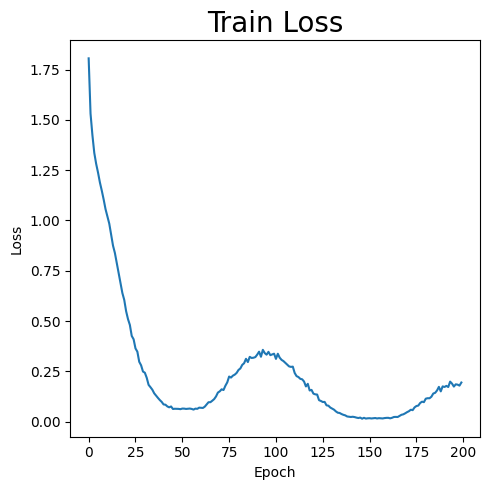

In [330]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Train Loss", fontsize=20)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
    # baseline = signal.medfilt(signal.medfilt(data, int(0.3 * 500) - 1) , int(0.7* 500) - 1)
ax1.plot(loss_list)
    # ax1.plot(baseline,"r")
    # ax1.plot(data-baseline,"g")
fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/Train_loss.png")

In [47]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score
label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
def extract_metrix(threshold, model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
    #             logits = logits.round()
            logits = logits > threshold
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
    #                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
    confusion = multilabel_confusion_matrix(gt_list,logits_list)
    print(f"==================== Threshold = {threshold} ====================")
    print(f"Exact Match Ratio, MR : : {accuracy_score(gt_list, logits_list)}")
    print(f"Hamming Loss : {hamming_loss(gt_list, logits_list)}")
    print(classification_report(gt_list, logits_list, target_names=label_names))
    print(confusion)
    MR = np.all(np.array(logits_list) == np.array(gt_list), axis=1).mean()
    return logits_list, gt_list

0.35 is Best Threshold

In [23]:
def Accuracy(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    acc = (TP+TN)/(TP+FP+TN+FN)
    return acc

def Precision(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    pre = (TP)/(TP+FP)
    return pre

def Recall(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    recall = (TP)/(TP+FN)
    return recall

def f1Score(conf):
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]
    TP = conf[1][1]
    pre = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f1score = (2*pre*recall)/(pre+recall)
    return f1score

In [21]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score
label_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
def extract_pr_re(threshold, model, test_loader):
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    pre = []
    rec = []
    acc = []
    f1s = []
    ham = []
    emr = []
    for th in threshold:
        logits_list = []
        gt_list = []
        print("Threshold :",th)
        model.eval()
        for step, (x,y) in enumerate(test_bar):
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                logits = model(x).cpu().detach().numpy()
        #             logits = logits.round()
                logits = logits > th
                logits = logits.astype(int)
                for l in logits:
                    logits_list.append(l)
                y = y.cpu().detach().numpy()
                for gt in y:
        #                 print(gt.astype(int))
                    gt_list.append(gt.astype(int))
        
        confu = multilabel_confusion_matrix(gt_list,logits_list)

        NORM = confu[0]
        MI = confu[1]
        STTC = confu[2]
        CD = confu[3]
        HYP = confu[4]
        
        ac = [Accuracy(NORM), Accuracy(MI), Accuracy(STTC), Accuracy(CD), Accuracy(HYP)]
        pr = [Precision(NORM), Precision(MI), Precision(STTC), Precision(CD), Precision(HYP)]
        re = [Recall(NORM), Recall(MI), Recall(STTC), Recall(CD), Recall(HYP)]
        f1 = [f1Score(NORM), f1Score(MI), f1Score(STTC), f1Score(CD), f1Score(HYP)]
        mr = accuracy_score(gt_list, logits_list)
        ha = hamming_loss(gt_list, logits_list)
        acc.append(ac)
        pre.append(pr)
        rec.append(re)
        f1s.append(f1)
        ham.append(ha)
        emr.append(mr)
    return pre,rec,acc,f1s,ham,emr

In [22]:
model_name = "Saved_ViT_model_FinalEpoch_16_0.0001_70.pth"
model_best = ViT().to(device)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
# model_best.load_state_dict(torch.load("models/Best_Saved_ViT_model_1121_400.13_16_210.pth")) #5e-5, 50, 8
model_best.load_state_dict(torch.load("models/1203/"+model_name))
# extract_metrix(0.7, best_models[-1][2], test_loader)
threshold = np.linspace(0,1,50)
# confu,clr = extract_pr_re(0.75, model_best, test_loader)
# class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4}

precisions, recalls, accuracys, f1Scores, hammings, emrs = extract_pr_re(threshold, model_best, test_loader)


  0%|                                                                           | 0/68 [00:00<?, ?it/s]

Threshold : 0.0


100%|██████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 37.50it/s]


NameError: name 'Accuracy' is not defined

In [40]:
for i, th in enumerate(threshold):
    if th >= 0.5 and th <= 0.8:
        print(i, end=" ")

25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [48]:
np_pre = np.array(precisions)
np_rec = np.array(recalls)
np_accuracy = np.array(accuracys)
np_f1 = np.array(f1Scores)
np_ham = np.array(hammings)
np_emr = np.array(emrs)

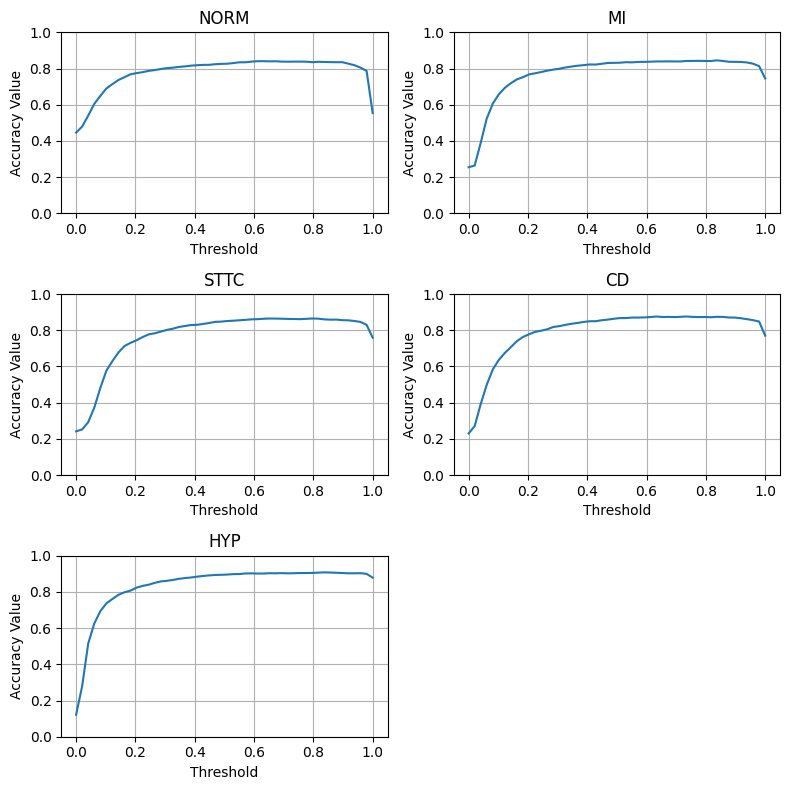

In [112]:
fig = plt.figure(figsize=(8,8))
for i in range(5):
    ax1 = fig.add_subplot(3,2,i+1)
    ax1.set_title(label_names[i])
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Accuracy Value")
    ax1.set_ylim(0,1)
    ax1.plot(threshold,np_accuracy[:,i],label="Accuracy")
    ax1.grid()
fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/Accuracy.png")

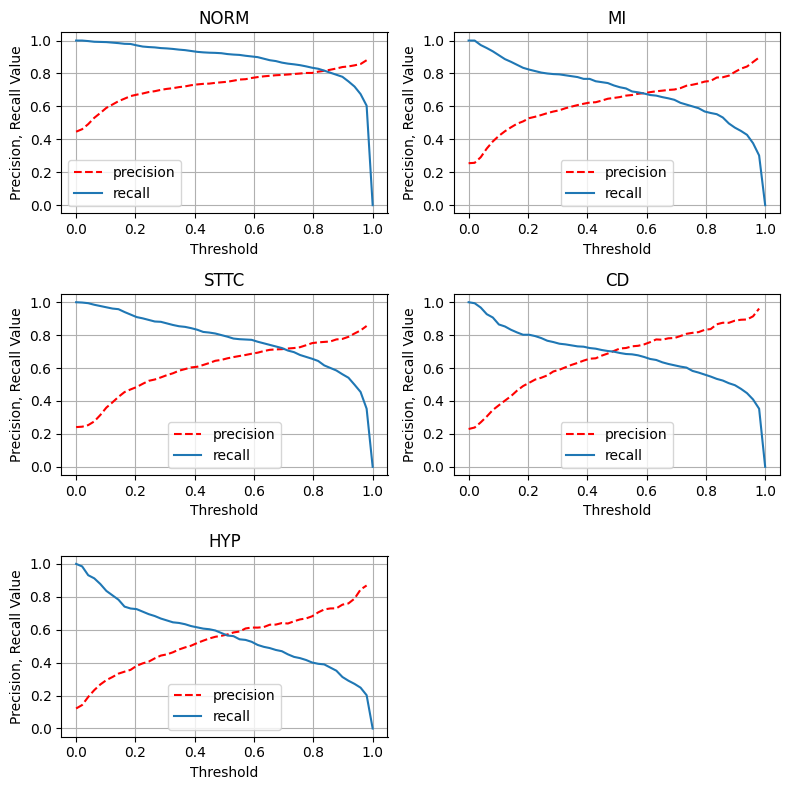

In [113]:
fig = plt.figure(figsize=(8,8))
for i in range(5):
    ax1 = fig.add_subplot(3,2,i+1)
    ax1.set_title(label_names[i])
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Precision, Recall Value")
    ax1.plot(threshold,np_pre[:,i],"r--",label="precision")
    ax1.plot(threshold,np_rec[:,i],label="recall")
    ax1.legend()
    ax1.grid()
fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/pre_rec.png")

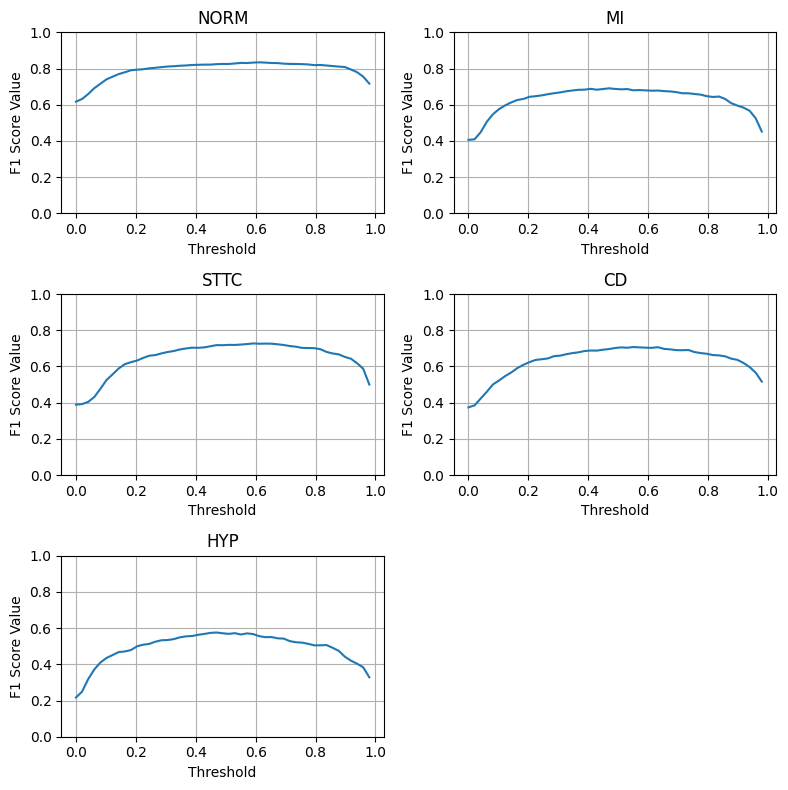

In [114]:
fig = plt.figure(figsize=(8,8))
for i in range(5):
    ax1 = fig.add_subplot(3,2,i+1)
    ax1.set_title(label_names[i])
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("F1 Score Value")
    ax1.set_ylim(0,1)
    ax1.plot(threshold,np_f1[:,i],label="F1 Score")
    ax1.grid()

fig.tight_layout()
fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/f1scores.png")

In [115]:
acc_df = pd.DataFrame(np.round(np_accuracy[25:40,:],3),columns=[["Accuracy"]*5,label_names])
pre_df = pd.DataFrame(np.round(np_pre[25:40,:],3),columns=[["Precision"]*5,label_names])
rec_df = pd.DataFrame(np.round(np_rec[25:40,:],3),columns=[["Recall"]*5,label_names])
f1_df = pd.DataFrame(np.round(np_f1[25:40,:],3),columns=[["F1 Score"]*5,label_names])
ham_df = pd.DataFrame(np.round(np_ham[25:40],5),columns=[["Hamming Loss"],["Mean"]])
emr_df = pd.DataFrame(np.round(np_emr[25:40],5),columns=[["Exact Match Ratio"],["Mean"]])
all_df = pd.concat([acc_df,pre_df,rec_df,f1_df,ham_df,emr_df], axis=1)
# np.round(threshold[25:40],3)
all_df = all_df.set_index(np.round(threshold[25:40],2))
all_df.to_csv(f"/data/graduate/MI_Detection_Transformer/Result_CSV.csv")

In [82]:
test_loader = get_DataLoader(x_test_d, y_test_d, batch=32, num_workers=1, shuffle=False)
model_name = "Saved_ViT_model_FinalEpoch_16_0.0001_70.pth"
model_best = ViT().to(device)
# model.load_state_dict(torch.load("Best_Saved_ViT_model_f192.pth"))
# model_best.load_state_dict(torch.load("models/Best_Saved_ViT_model_1121_400.13_16_210.pth")) #5e-5, 50, 8
model_best.load_state_dict(torch.load("models/1203/"+model_name))
# extract_metrix(0.7, best_models[-1][2], test_loader)
logit, act = extract_metrix(0.73, model_best, test_loader)
# extract_metrix(0.75, model, test_loader)

100%|██████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 37.09it/s]

==================== Threshold = 0.73 ====================
Exact Match Ratio, MR : : 0.5866543095458758
Hamming Loss : 0.14216867469879518
              precision    recall  f1-score   support

        NORM       0.75      0.92      0.83       963
          MI       0.80      0.49      0.61       550
        STTC       0.75      0.58      0.65       521
         HYP       0.81      0.53      0.64       496
          CD       0.69      0.44      0.53       262

   micro avg       0.76      0.66      0.71      2792
   macro avg       0.76      0.59      0.65      2792
weighted avg       0.76      0.66      0.69      2792
 samples avg       0.73      0.70      0.70      2792

[[[ 897  298]
  [  75  888]]

 [[1542   66]
  [ 280  270]]

 [[1535  102]
  [ 221  300]]

 [[1600   62]
  [ 231  265]]

 [[1845   51]
  [ 148  114]]]



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
for i, l in enumerate(logit):
    flag = True
    for j, v in enumerate(l):
        if v == act[i][j]:
            continue
        else:
            flag=False
    if flag:
        print(i,l, act[i])

0 [1 0 0 0 0] [1 0 0 0 0]
2 [1 0 0 0 0] [1 0 0 0 0]
3 [1 0 0 0 0] [1 0 0 0 0]
4 [1 0 0 0 0] [1 0 0 0 0]
7 [1 0 0 0 0] [1 0 0 0 0]
8 [1 0 0 0 0] [1 0 0 0 0]
9 [1 0 0 0 0] [1 0 0 0 0]
10 [1 0 0 0 0] [1 0 0 0 0]
11 [1 0 0 0 0] [1 0 0 0 0]
12 [1 0 0 0 0] [1 0 0 0 0]
13 [1 0 0 0 0] [1 0 0 0 0]
14 [0 0 1 0 0] [0 0 1 0 0]
15 [1 0 0 0 0] [1 0 0 0 0]
16 [1 0 0 0 0] [1 0 0 0 0]
17 [1 0 0 0 0] [1 0 0 0 0]
18 [1 0 0 0 0] [1 0 0 0 0]
20 [1 0 0 0 0] [1 0 0 0 0]
21 [1 0 0 0 0] [1 0 0 0 0]
22 [0 0 0 1 0] [0 0 0 1 0]
28 [0 0 0 1 0] [0 0 0 1 0]
29 [1 0 0 0 0] [1 0 0 0 0]
30 [1 0 0 0 0] [1 0 0 0 0]
31 [1 0 0 0 0] [1 0 0 0 0]
35 [1 0 0 0 0] [1 0 0 0 0]
36 [1 0 0 0 0] [1 0 0 0 0]
38 [1 0 0 0 0] [1 0 0 0 0]
41 [0 0 1 0 1] [0 0 1 0 1]
42 [0 0 1 0 0] [0 0 1 0 0]
43 [1 0 0 0 0] [1 0 0 0 0]
44 [0 0 1 0 1] [0 0 1 0 1]
46 [1 0 0 0 0] [1 0 0 0 0]
47 [1 0 0 0 0] [1 0 0 0 0]
50 [0 0 1 0 0] [0 0 1 0 0]
51 [1 0 0 0 0] [1 0 0 0 0]
53 [1 0 0 0 0] [1 0 0 0 0]
55 [0 0 1 0 0] [0 0 1 0 0]
57 [1 0 0 0 0] [1 0 0 0 0]
58 [0 0 

In [88]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, accuracy_score
label_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
def extract_conf(threshold, model, test_loader):
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    # print("Threshold :",th)
    model.eval()
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
    #             logits = logits.round()
            logits = logits > threshold
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
    #                 print(gt.astype(int))
                gt_list.append(gt.astype(int))
    
    confu = multilabel_confusion_matrix(gt_list,logits_list)
    print(confu)
    NORM = confu[0]
    MI = confu[1]
    STTC = confu[2]
    CD = confu[3]
    HYP = confu[4]
        
    return NORM,MI,STTC,CD,HYP

In [97]:
model_name = "Saved_ViT_model_FinalEpoch_16_0.0001_200_asy_bias.pth"
model_best = ViT().to(device)
model_best.load_state_dict(torch.load("models/1202/"+model_name))
# c_norm, c_mi, c_sttc, c_cd, c_hyp = extract_conf(0.73, model_best, test_loader)

<All keys matched successfully>

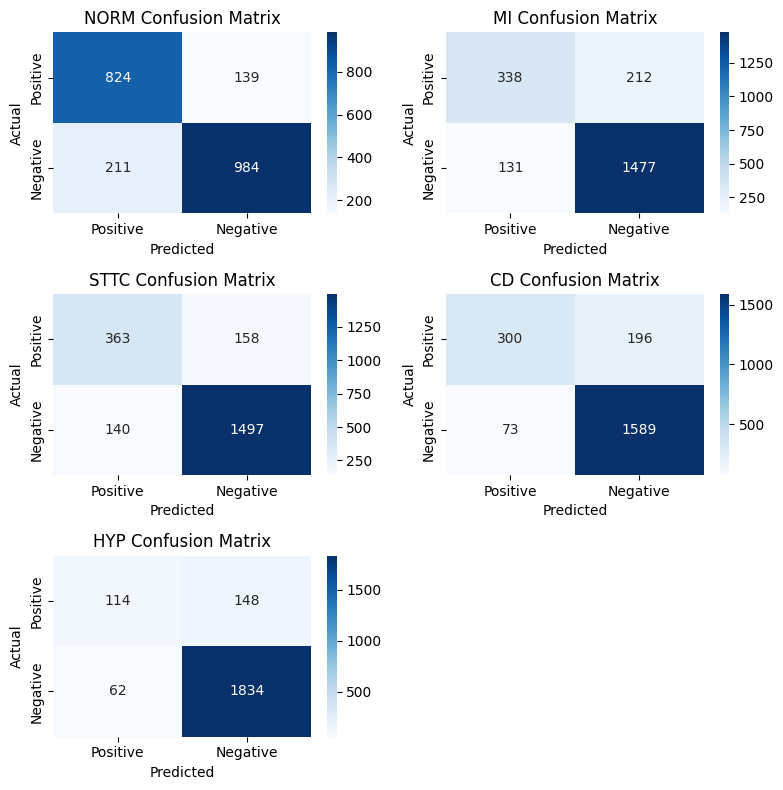

In [116]:
# c_norm, c_mi, c_sttc, c_cd, c_hyp
fig = plt.figure(figsize=(8,8))
hmap = [c_norm, c_mi, c_sttc, c_cd, c_hyp]
cls = ["NORM","MI","STTC","CD","HYP"]
for i in range(5):
    conf = hmap[i]
    TN = int(conf[0][0])
    FP = int(conf[0][1])
    FN = int(conf[1][0])
    TP = int(conf[1][1])
    c = [[TP,FN],[FP,TN]]
    ax1 = fig.add_subplot(3,2,i+1)
    sns.heatmap(c, annot=True, cmap="Blues", fmt="g")
    ax1.set_xticks([0.5,1.5],["Positive","Negative"])
    ax1.set_yticks([0.5,1.5],["Positive","Negative"])
    ax1.set_title(f"{cls[i]} Confusion Matrix")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
fig.tight_layout()
# conf_extract_Cmap(c_norm, "NORM Confusion Matrix")
# conf_extract_Cmap(c_mi, "MI Confusion Matrix")
# conf_extract_Cmap(c_sttc, "STTC Confusion Matrix")
# conf_extract_Cmap(c_cd, "CD Confusion Matrix")
# conf_extract_Cmap(c_hyp, "HYP Confusion Matrix")
fig.savefig(f"/data/graduate/MI_Detection_Transformer/cfmt.png")

119 119
torch.Size([12, 5000]) tensor([0., 0., 0., 1., 0.])
torch.Size([1, 251, 768]) torch.Size([1, 6, 251, 251])
torch.Size([1, 6, 251, 251])
(5000, 6)
tensor([0., 0., 0., 1., 0.])


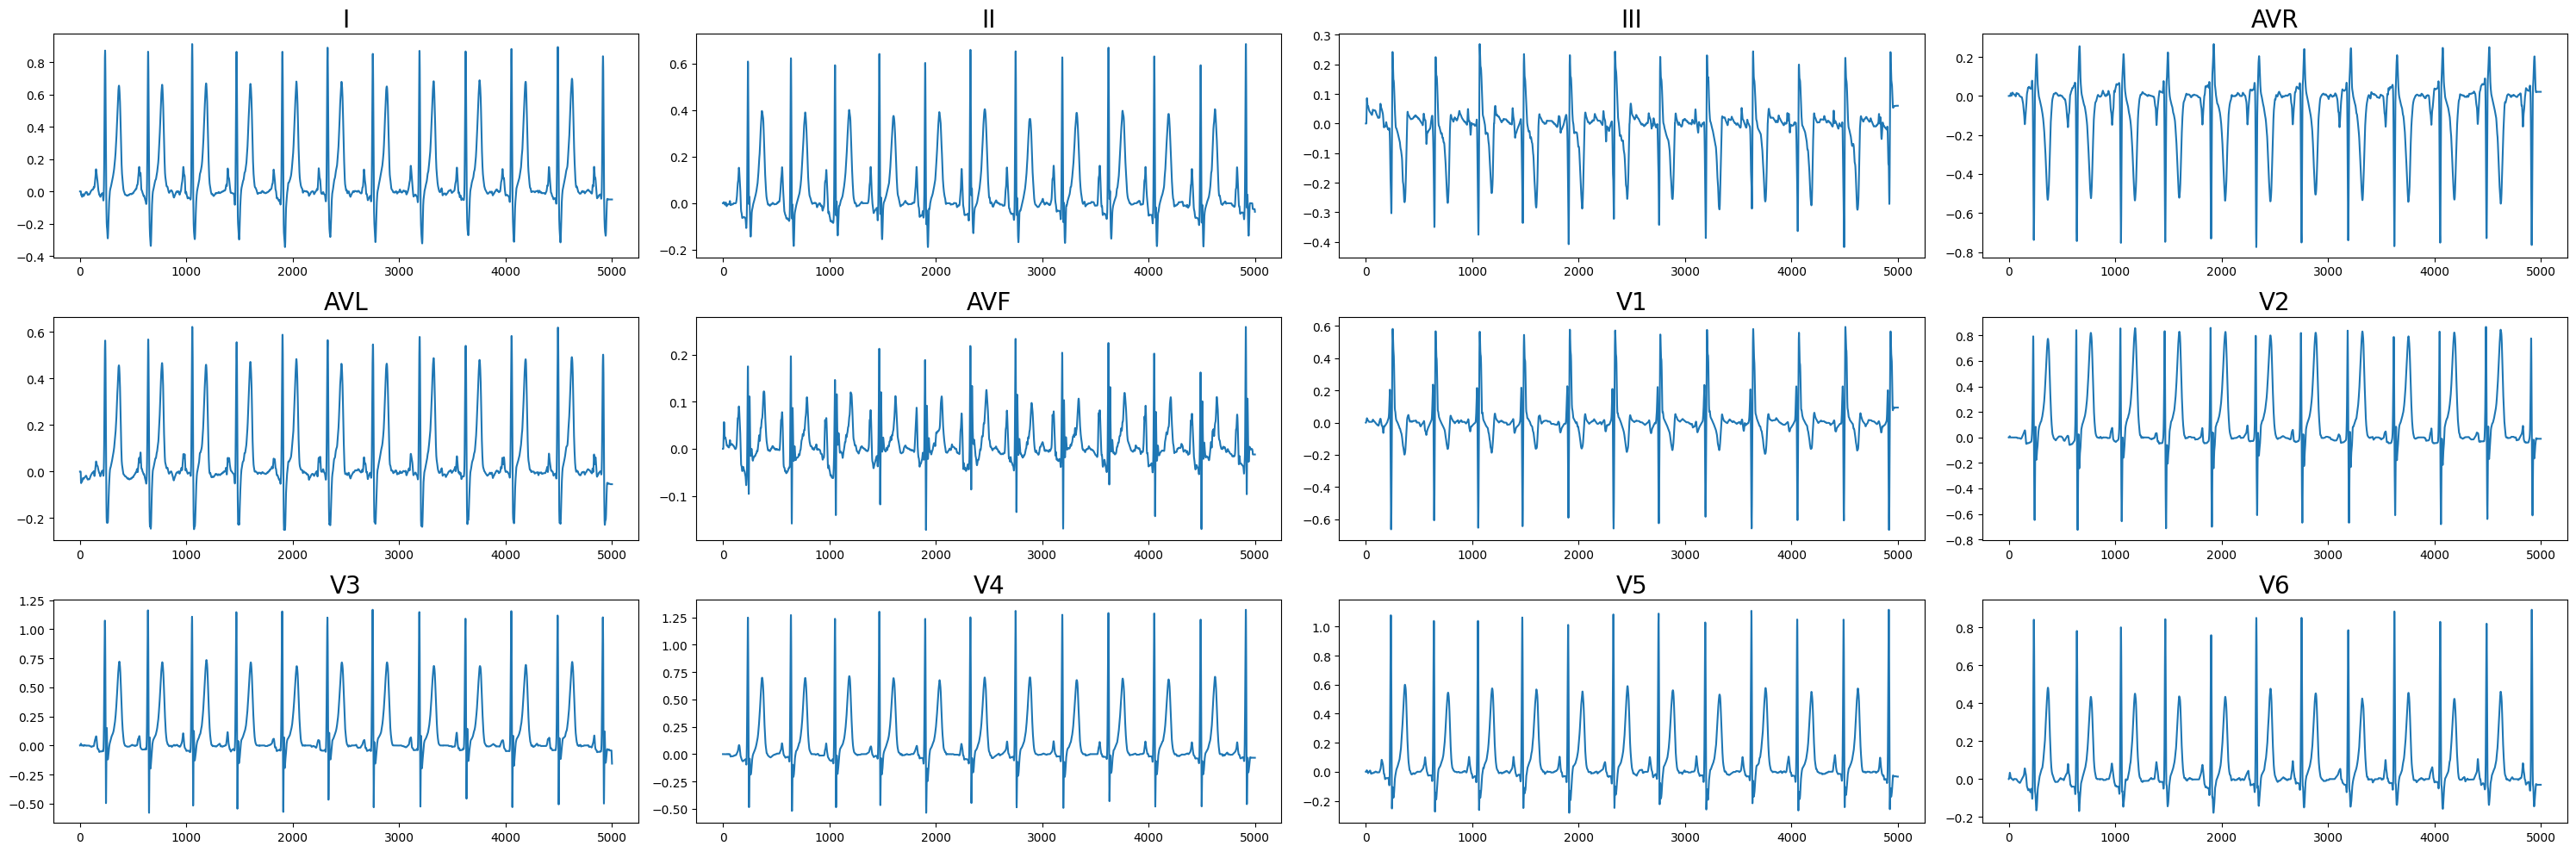

In [161]:
model_name = "Saved_ViT_model_FinalEpoch_16_0.0001_200_asy_bias.pth"
model_best = ViT().to(device)
model_best.load_state_dict(torch.load("models/1202/"+model_name))

sel = 119
def get_data(test_loader, sel):
    count = 0
    for i, (x,y) in enumerate(test_loader):
        for idx in range(32):
            if count == sel:
                print(count, sel)
                return x[idx], y[idx]
            count+=1

d_test, d_label = get_data(test_loader, sel)
print(d_test.shape,d_label)
test_signal = d_test
test_signal = test_signal.unsqueeze(0)
attns = model_best.get_last_selfattention(test_signal.cuda())
print(attns.shape)
# attns = torch.unsqueeze(attns,1)
attn = attns[0,:,0,1:]
attn = torch.transpose(attn, 1, 0)
attn = torch.unsqueeze(torch.unsqueeze(attn, 0), 0)
attn = Func.interpolate(attn, size=(5000, 6), mode='bicubic')[0, 0]
attn = attn.detach().cpu().numpy()
print(attn.shape)
p_signal = test_signal[0].transpose(1,0).detach().numpy()
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
print(d_label)
for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(p_signal[:,i])
fig.tight_layout()
# class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4}

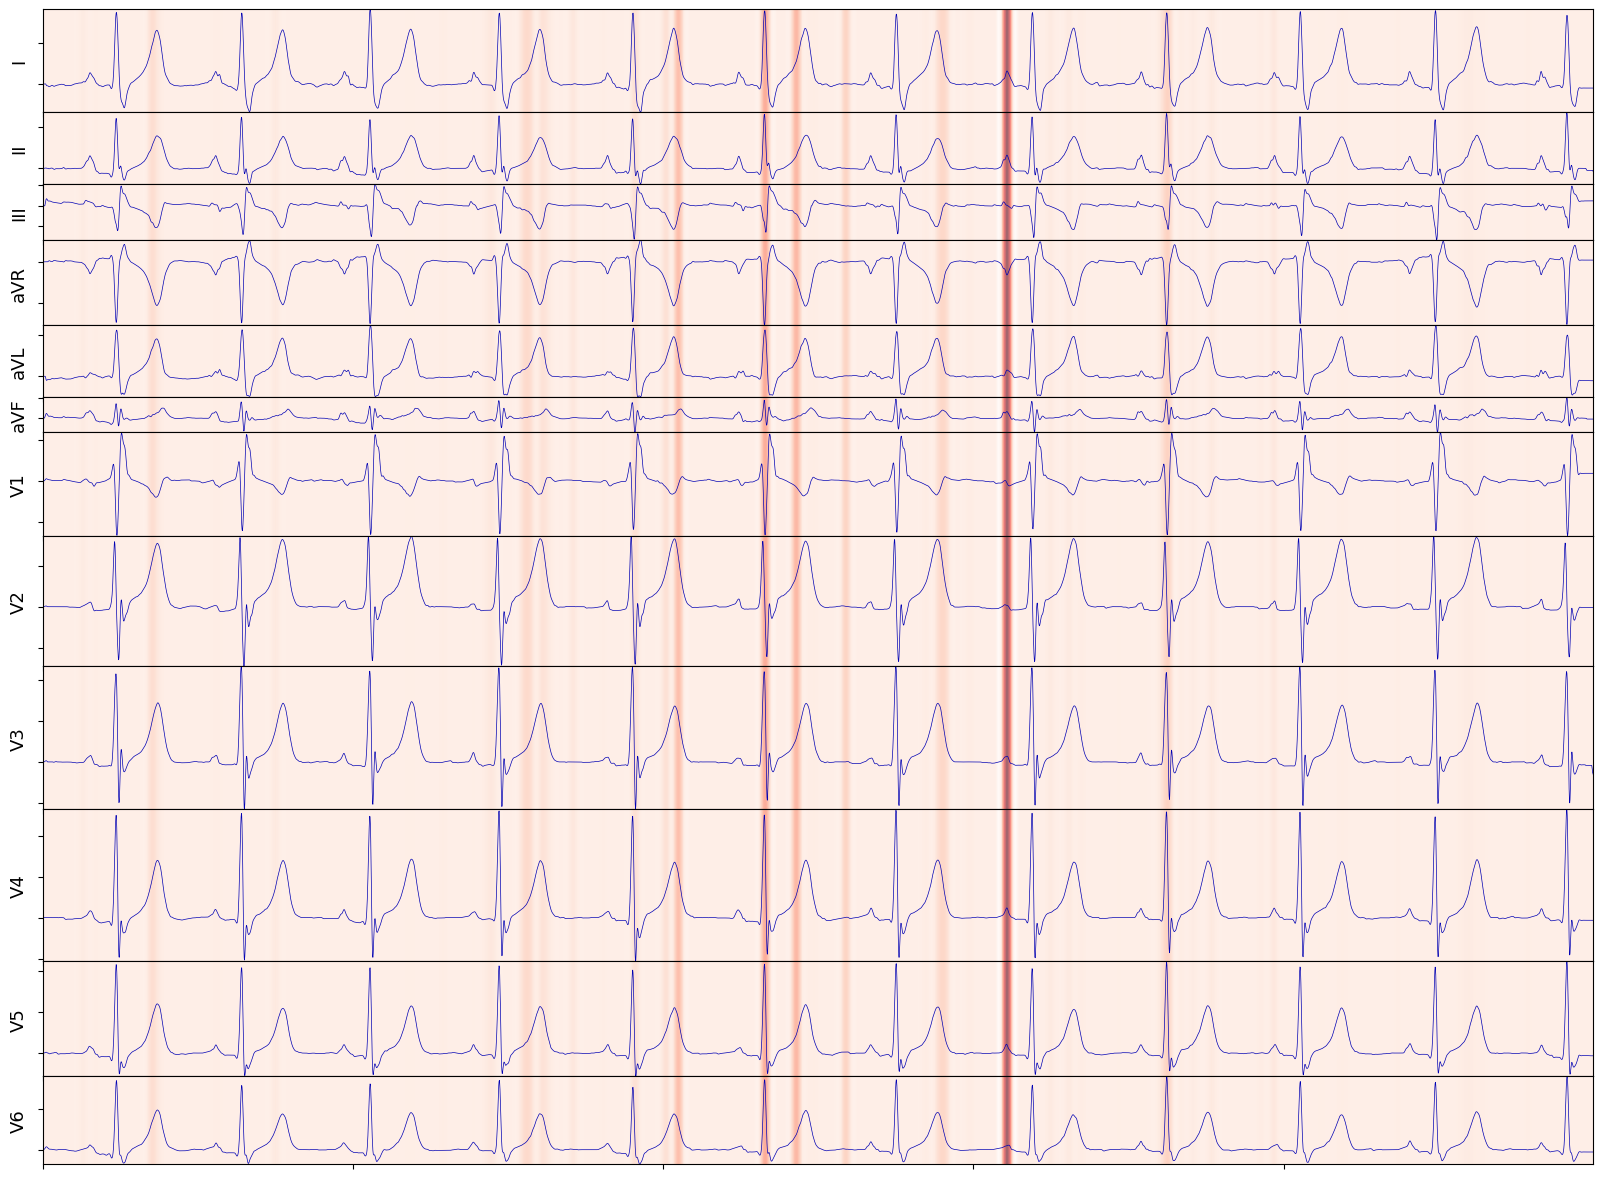

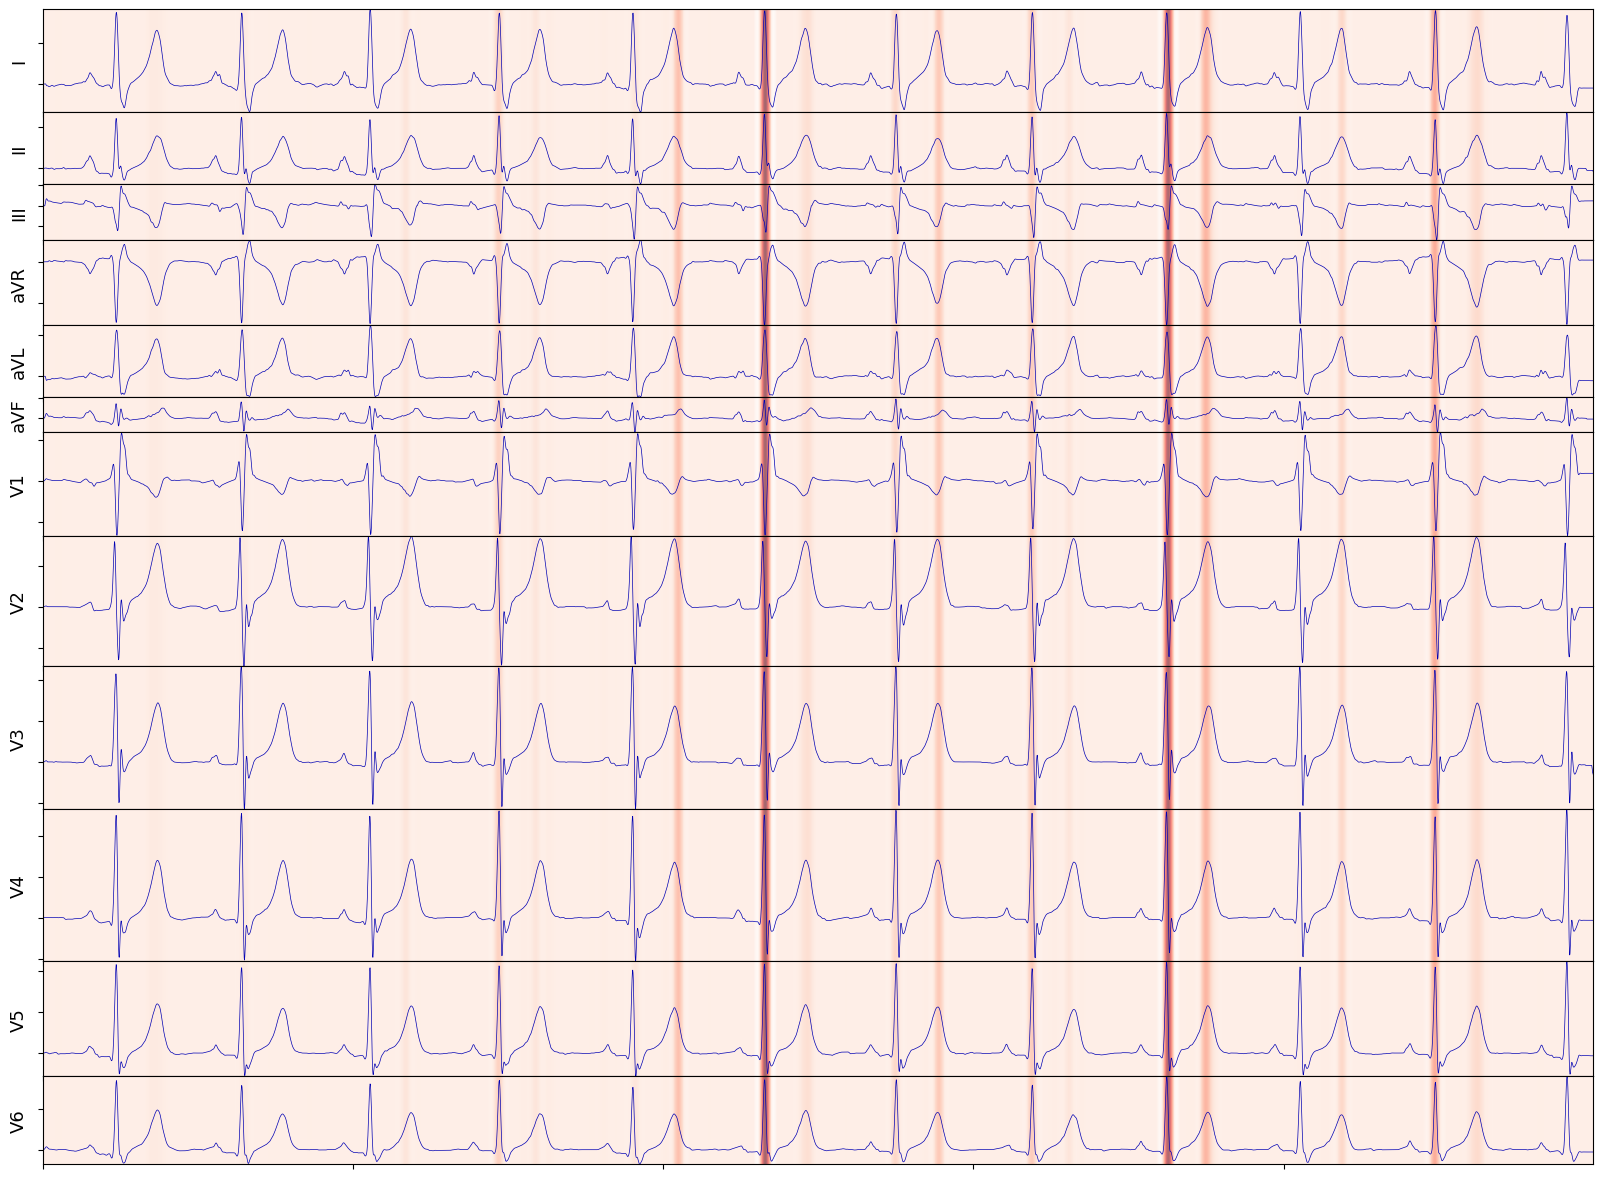

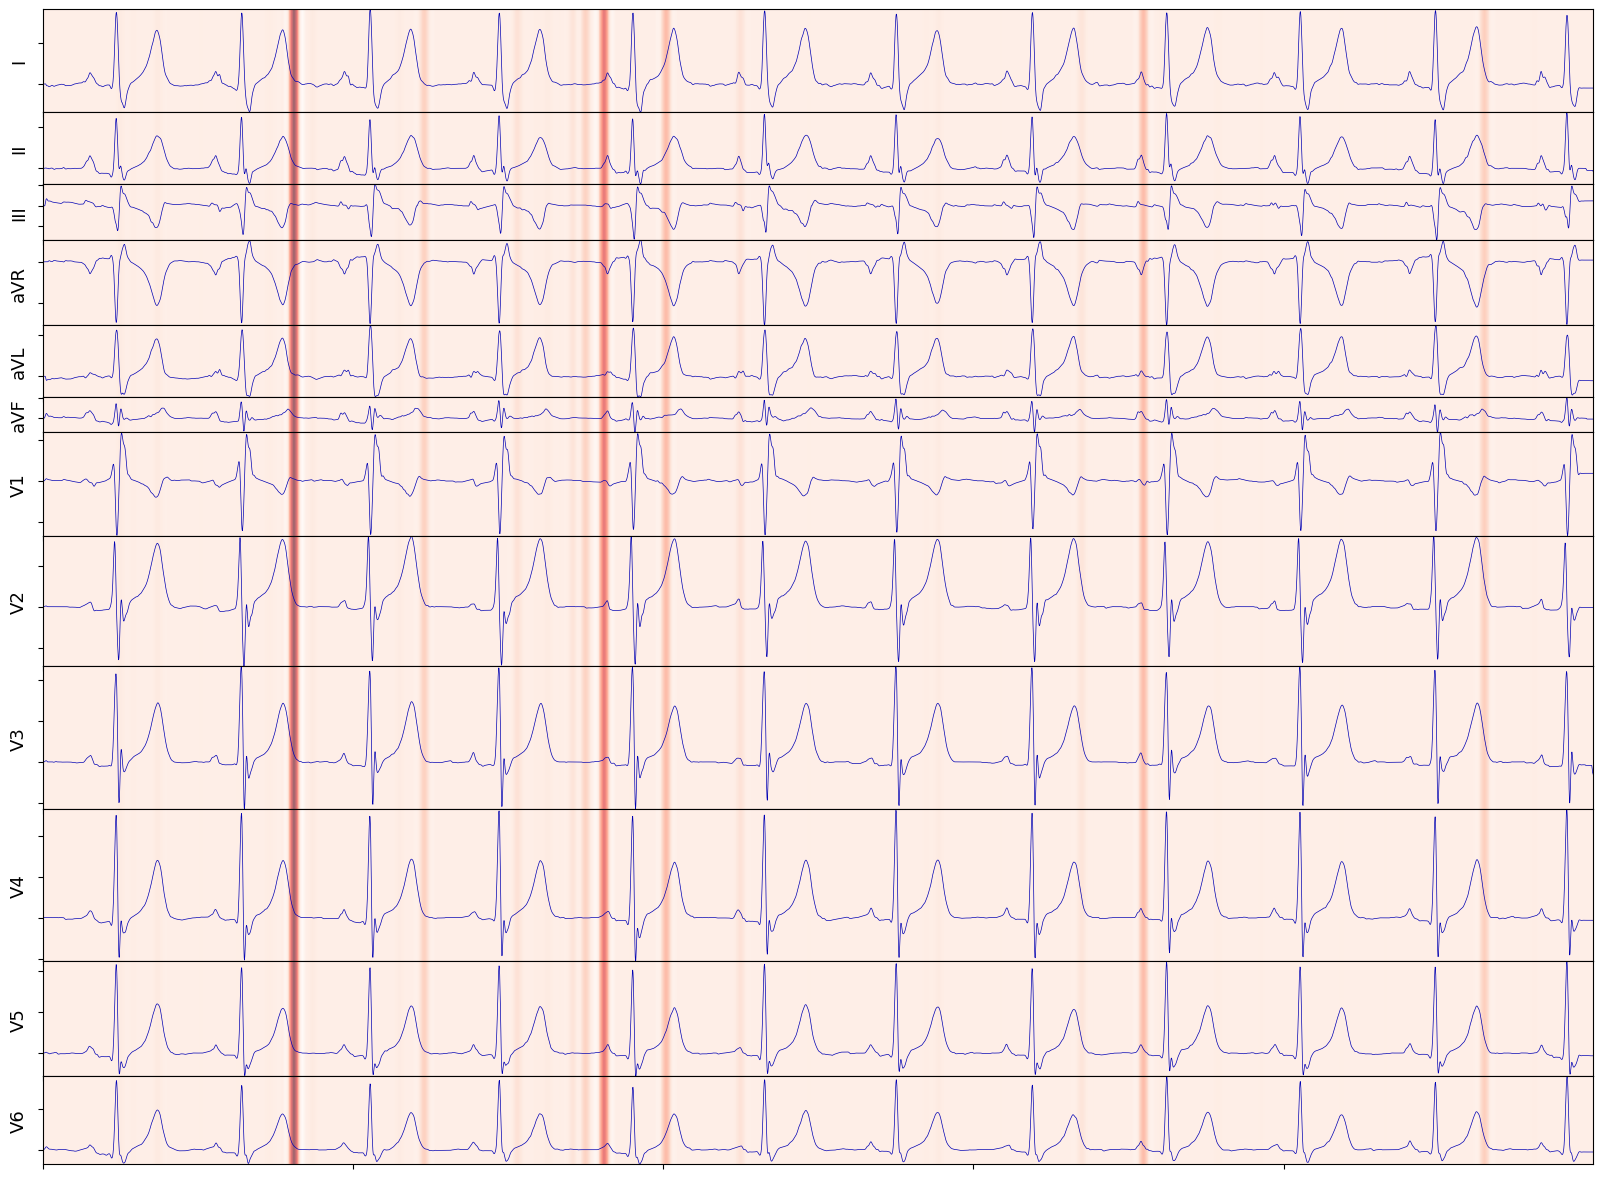

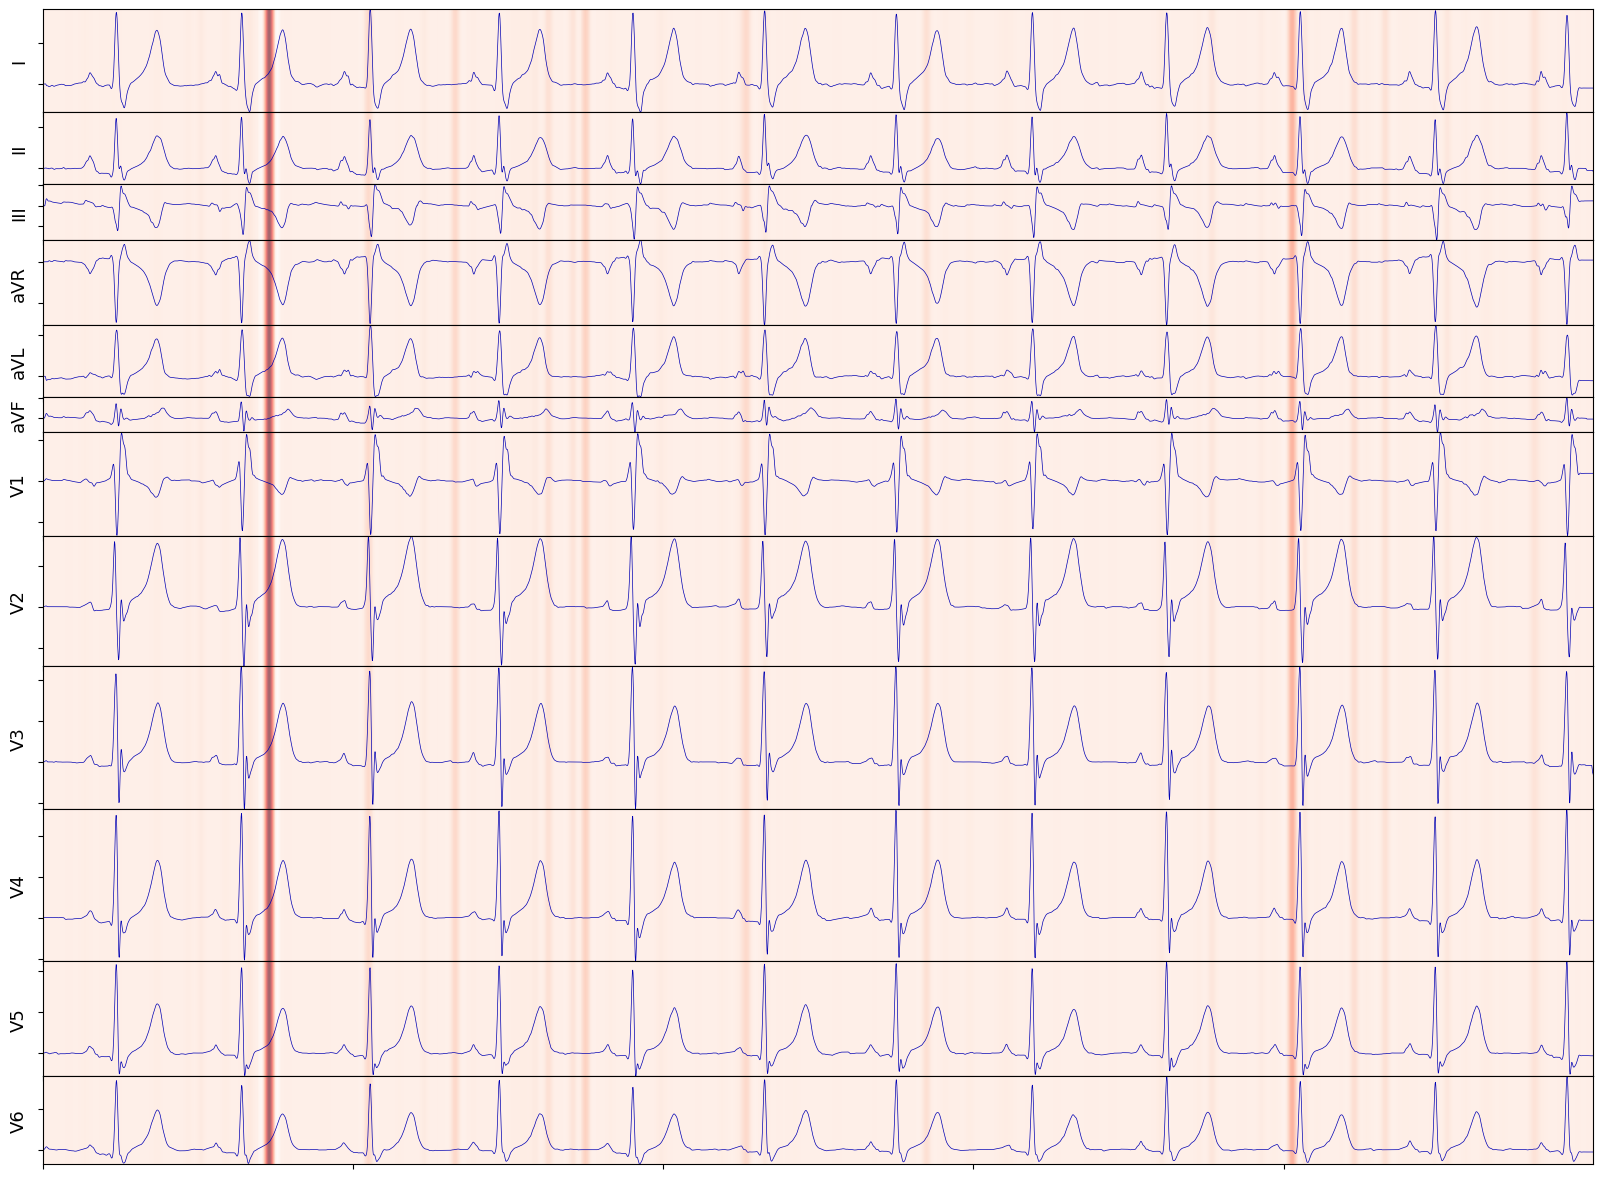

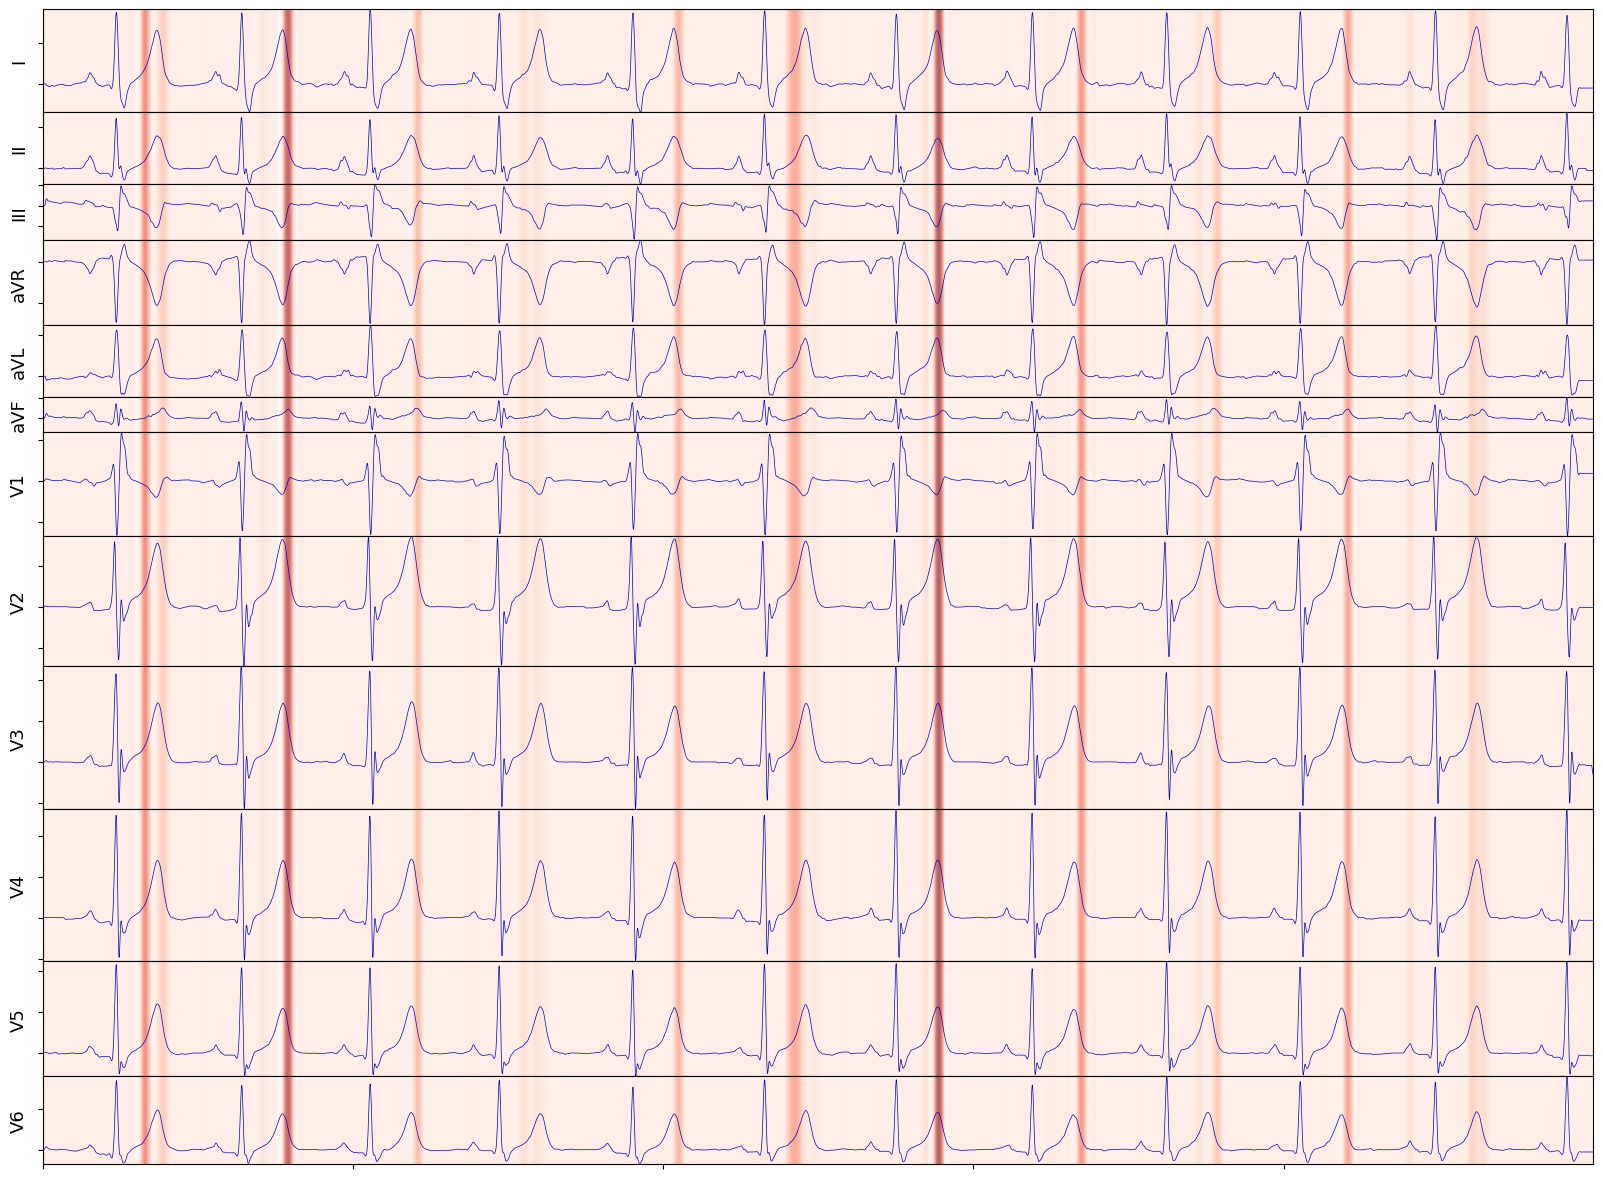

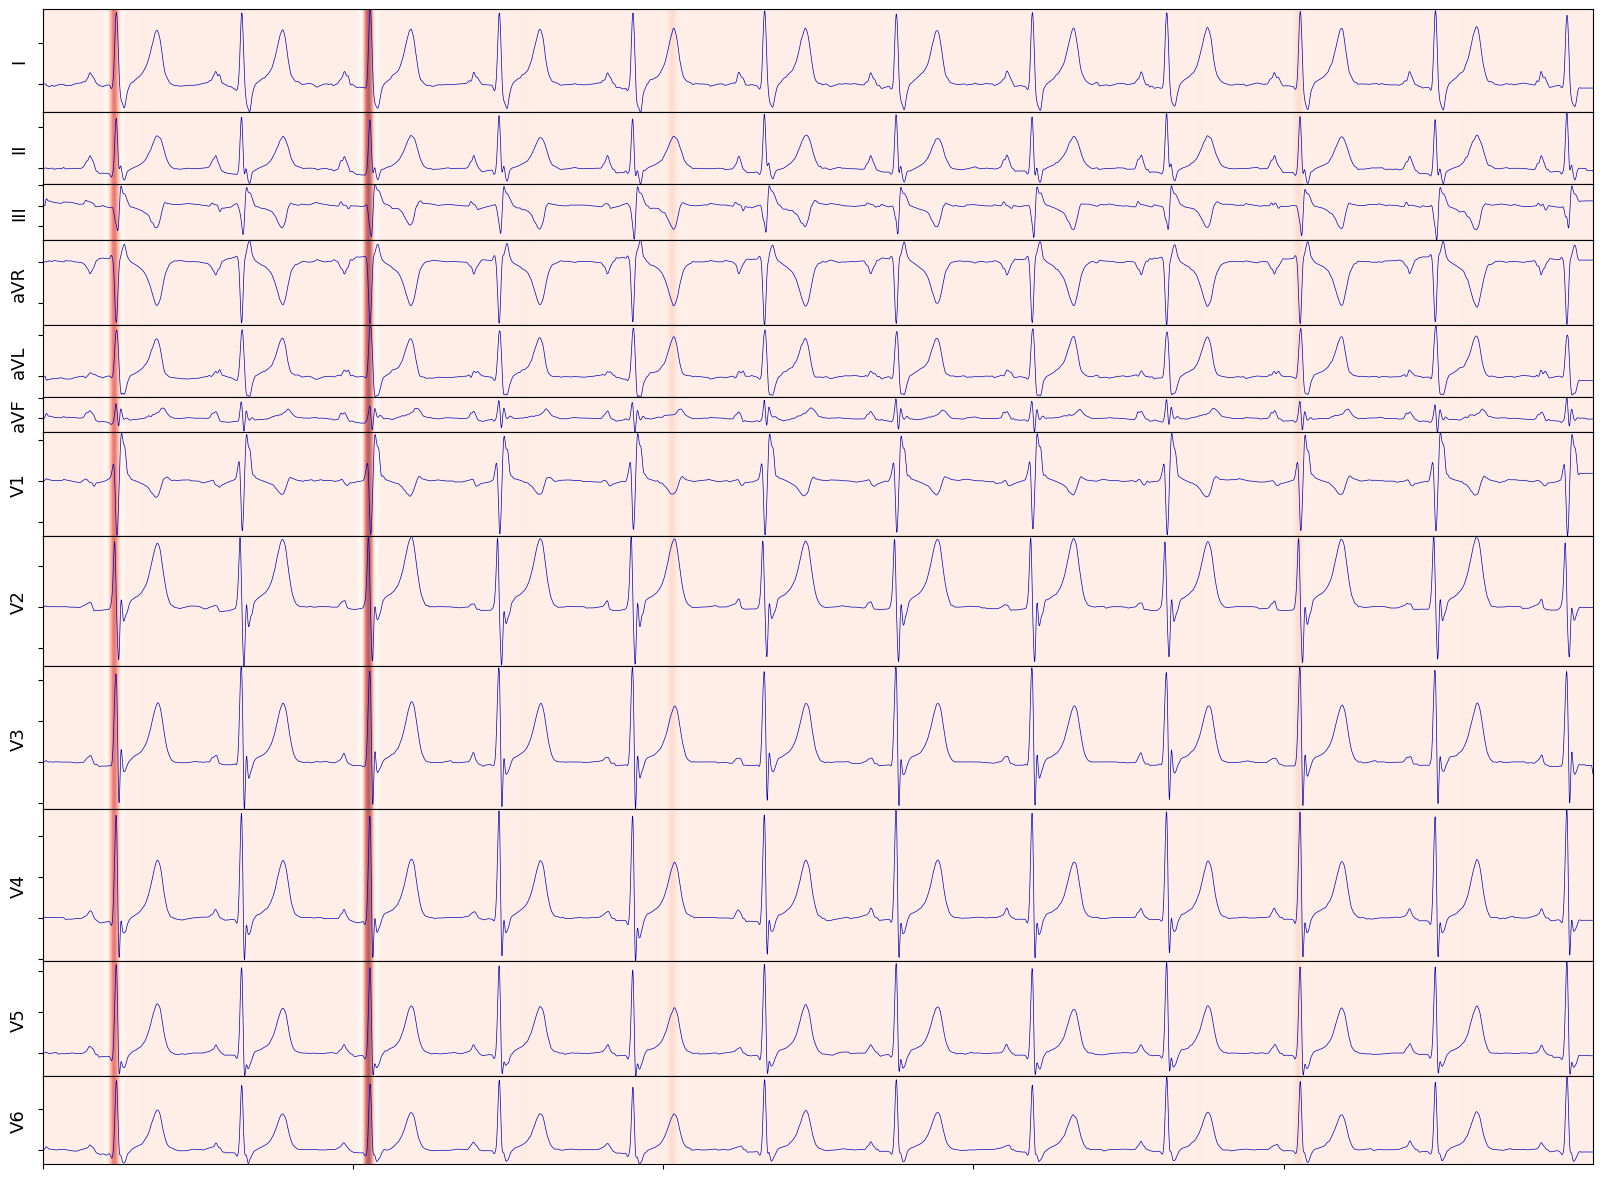

In [163]:
def plot_ax(ax, signal, sampling_rate, plot_grid=True):
    color_line = (0, 0, 0.7)
    color_major = (1, 0, 0)
    color_minor = (1, 0.7, 0.7)

    ax.plot(np.arange(0, len(signal)), signal, linewidth=0.5, color=color_line)

    if plot_grid:
        # set major grid
        xmajor = np.arange(0, len(signal), sampling_rate * 0.2)
        ymajor = np.arange(signal.min(), signal.max(), 0.5)
        ax.set_xticks(xmajor, minor=False)
        ax.set_xticks(xmajor, minor=False)
        ax.set_yticks(ymajor, minor=False)
        ax.grid(which="major", color=color_major, linewidth=0.5)

        # set minor grid
        xminor = np.arange(0, len(signal), sampling_rate * 0.04)
        yminor = np.arange(signal.min(), signal.max(), 0.1)
        ax.set_xticks(xminor, minor=True)
        ax.set_yticks(yminor, minor=True)
        ax.grid(which="minor", color=color_minor, linewidth=0.5)

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    ax.margins(0)

    ax.set_ylim(signal.min(), signal.max())
    
def plot_12(ecg, sampling_rate, plot_grid=True):
    "This function is ridiculously slow and there are mutch better ways to implemt"
    figsize = (20, 15)

    height_ratios = [ecg[:, i].max() - ecg[:, i].min() for i in range(12)]
    height_ratios = [i / height_ratios[0] for i in height_ratios]
    fig, axs = plt.subplots(12, 1, figsize=figsize, gridspec_kw={"height_ratios": height_ratios})
    fig.subplots_adjust(hspace=0.0)
    for i, ax in enumerate(axs):
        plot_ax(ax, ecg[:, i], sampling_rate, plot_grid=plot_grid)
        ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), attn[:, head][np.newaxis], cmap="Reds", alpha=0.6)
        ax.set_ylabel(lead_index[i], fontsize=13)
        
    return fig, axs

#python plot_attention.py sadd/JS05865 vit_best/ 6
lead_index = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
# lead = 3
for head in range(6):
    # for lead in range(12):
        # fig, ax = plt.subplots(figsize=(10, 1.5))
        # plot_ax(ax, signal=p_signal[:,lead], plot_grid=False, sampling_rate=500)
        # ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), attn[:, head][np.newaxis], cmap="Reds", alpha=0.6)
    fig, axs = plot_12(p_signal,500,False)
    fig.savefig(f"/data/graduate/MI_Detection_Transformer/attention_result/head_{head}_1218_CD_RBBB.png")
        # ax.set_ylabel(lead_index[lead], fontsize=13)